In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.metrics import log_loss

from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [2]:
#Reading File train 
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


<h1>Creating a new feature Preferential Attachment</h1>

In [3]:
def PA_follower(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        return len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
        
    except:
        #print("Something went wrong in PA_follower please check it once")
        return 0

In [4]:
def PA_followee(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        return len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b))) 
    except:
        return 0
    

In [5]:
#Again reading the data frame to get source and destination nodes
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [6]:
df_final_train['PA_followers'] = df_final_train.apply(lambda row:
                                            PA_follower(row['source_node'],row['destination_node']),axis=1)
df_final_test['PA_followers'] = df_final_test.apply(lambda row:
                                            PA_follower(row['source_node'],row['destination_node']),axis=1)

In [7]:
df_final_train['PA_followee'] = df_final_train.apply(lambda row:
                                            PA_followee(row['source_node'],row['destination_node']),axis=1)
df_final_test['PA_followee'] = df_final_test.apply(lambda row:
                                            PA_followee(row['source_node'],row['destination_node']),axis=1)

<h1>Creating another New feature SVD_DOT</h1>

In [8]:
def svd_dot_fun(a,b):
    temp=0
    for i,j in zip(a,b):
        temp=temp+i*j
    return temp

In [9]:
#Creating another Feature svd_dot
U=['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6']
V=['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']


In [10]:
U1=['svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']
V1=['svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']


In [11]:
df_final_test['svd_dot_u']=df_final_test.apply(lambda row: svd_dot_fun(row[U],row[V]),axis=1)
df_final_test['svd_dot_v']=df_final_test.apply(lambda row: svd_dot_fun(row[U1],row[V1]),axis=1)

In [12]:
df_final_train['svd_dot_u']=df_final_train.apply(lambda row: svd_dot_fun(row[U],row[V]),axis=1)
df_final_train['svd_dot_v']=df_final_train.apply(lambda row: svd_dot_fun(row[U1],row[V1]),axis=1)


In [13]:
#writing the df_final_train, df_final_test into csv files with new features svd_dot and Preferential Attachment 
df_final_train.to_csv('df_final_train.csv')
df_final_test.to_csv('df_final_test.csv')

In [14]:
#by suing these two files, we can avoid running above code 
df_final_train=pd.read_csv('df_final_train.csv',index_col=None)
df_final_test=pd.read_csv('df_final_train.csv')


<h1>Creating a train,test,CV split</h1>

In [15]:
X_train,X_cv=train_test_split(df_final_train,test_size=0.20)
y_train=X_train.indicator_link
y_cv=X_cv.indicator_link
y_test=df_final_test.indicator_link
X_test=df_final_test

In [16]:
X_train.drop(['source_node', 'destination_node', 'indicator_link','Unnamed: 0'],inplace=True,axis=1)
X_cv.drop(['source_node', 'destination_node', 'indicator_link','Unnamed: 0'],inplace=True,axis=1)
X_test.drop(['source_node', 'destination_node', 'indicator_link','Unnamed: 0'],inplace=True,axis=1)


In [17]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h1>Building a model using with XGBoost</h1>

[17:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:32:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

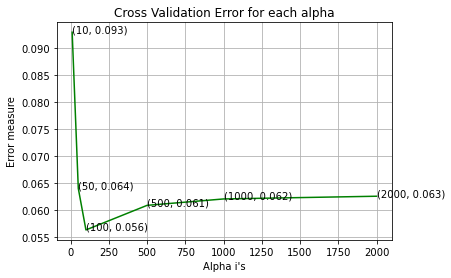

In [18]:
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



<h1>Final Model with best HyperParameters</h1>

[18:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

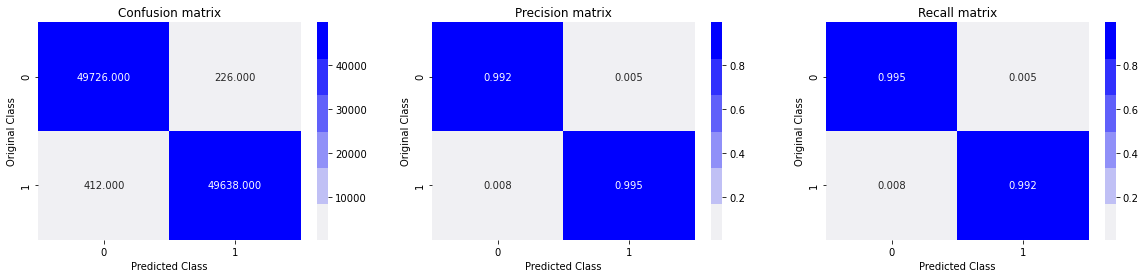

The Best f1 score  for train is   0.9969531991409021
The Best f1 score for test is  0.9936145084772905
The Best f1 score for CV is  0.9801311144730207


In [19]:
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))
train_sc = f1_score(y_train,sig_clf.predict(X_train))
print('The Best f1 score  for train is  ', train_sc)
test_sc = f1_score(y_test,sig_clf.predict(X_test))
print('The Best f1 score for test is ', test_sc)
CV_sc=f1_score(y_cv,sig_clf.predict(X_cv))
print('The Best f1 score for CV is ', CV_sc)

In [20]:
clf=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
clf.fit(X_train,y_train)


[18:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              nthread=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<h1>Feature importance</h1>


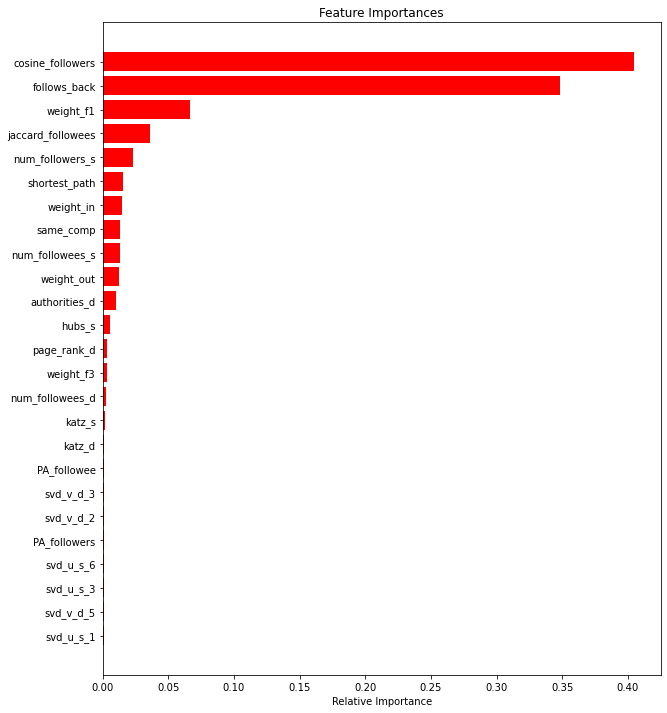

In [28]:
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<h1>Summary</h1>
1.In this case study we add two features Preferential Attachment and svd_dot<br>
2.Build a XGBoost model with best hyperparameter of alpha 100, and got a test loss of 0.02 which is the best value for this model.<br>
3. Confusion matrix and f1 score also shows a great results<br>
4.f1 Score is around 0.99<br>
5. Coming to the feature importance cosine_follower,follows_back are the top 2 important features.

<h1>Steps followed to slove the FaceBook predicition caseStudy</h1>
1.We defined the machine learning problem, i.e is to predict the whether a relation might exists in the future between two persons or not<br>
2.After seeing the dataset we analysied that we have only, possitive class data i.e we have only graph data where a link is present . From that we can say that we have only possitive class, so we added some random data as class 0, where no link is present between them.<br>
3.Now to handle the graph data we will use a library callled networkx which will handle the graph data, this module will play an important role in finding the various metrics about the directed graph.<br>
4.Now we will do some feature engineering, to get new features such as Jaccard& cosine similarities, PageRank, Shortest path,Adar index etc.<br>
5.We made a train test split randomly as we don't have any timestamp data.<br>
6.Now based on the above data we built various models, such as linear Regression, Randomforest,XGBoost etc.and calculated various metric related to that models and found that the above XGBoost model will perform well.<br>
